In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
train = pd.read_csv('train.csv')

In [3]:
train['BathPerRoom'] = (train['FullBath'] + 0.5 * train['HalfBath']) / train['BedroomAbvGr']
train['IsMultiFamily'] = train['KitchenAbvGr'] > 1

In [4]:
from sklearn.cluster import KMeans
features = train[['BedroomAbvGr', 'FullBath', 'KitchenAbvGr', 'GrLivArea']]
kmeans = KMeans(n_clusters=3, random_state=42)
train['HouseType'] = kmeans.fit_predict(features)

In [5]:
train['BathRatio'] = (train['FullBath'] + 0.5 * train['HalfBath'])
train['LivingPerRoom'] = train['GrLivArea'] / train['TotRmsAbvGrd']
train['ShareabilityScore'] = (train['BathRatio'] * 0.7) + (train['LivingPerRoom'] * 0.3)

In [6]:
threshold = train['ShareabilityScore'].quantile(0.7)
train['HouseCategory'] = 'Traditional/Solo'
train.loc[train['ShareabilityScore'] >= threshold, 'HouseCategory'] = 'Beyond Families'

In [7]:
%matplotlib inline

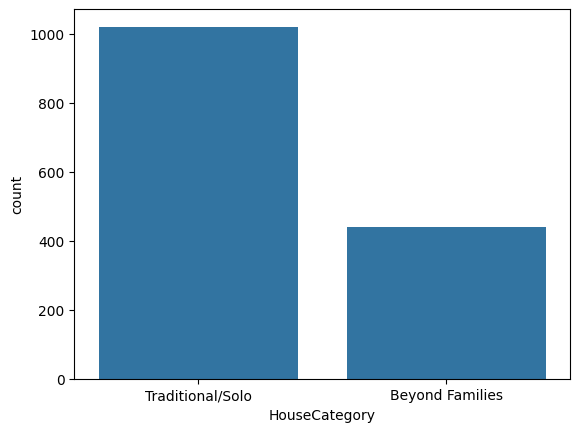

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='HouseCategory', data=train)

plt.show()

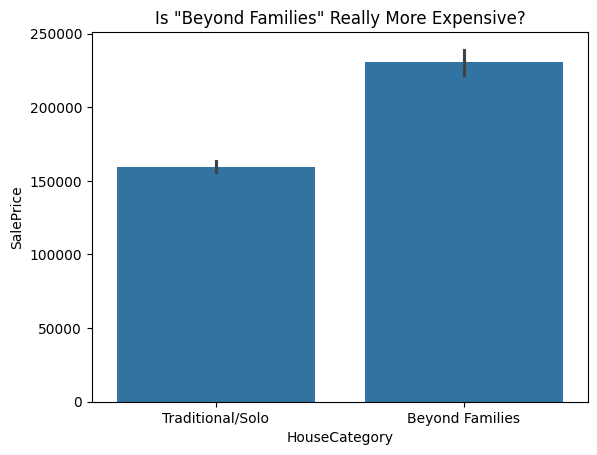

In [9]:
sns.barplot(x='HouseCategory', y='SalePrice', data=train)
plt.title('Is "Beyond Families" Really More Expensive?')
plt.show()

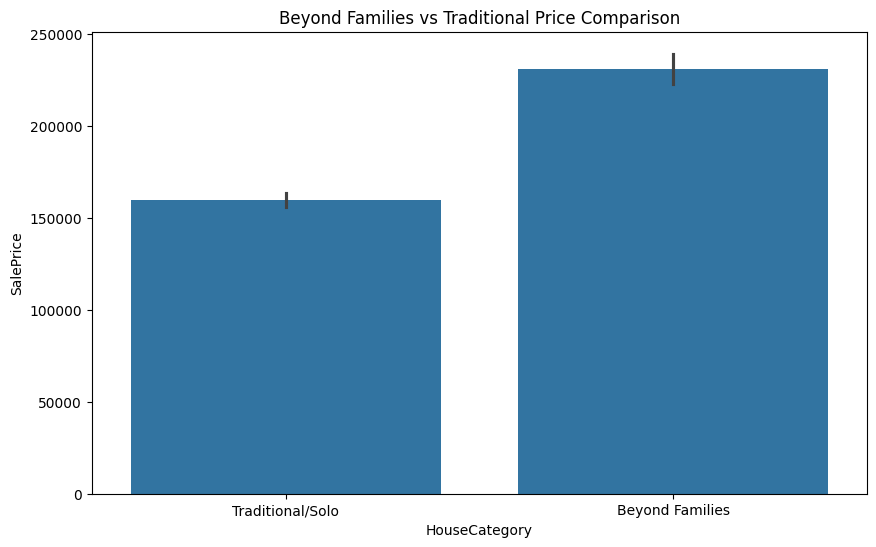

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(x='HouseCategory', y='SalePrice', data=train)
plt.title('Beyond Families vs Traditional Price Comparison')
plt.savefig('sharehouse_price_diff.png')

In [11]:
qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
train['KitchenQualNum'] = train['KitchenQual'].map(qual_map)
train['Ultimate_Share_Score'] = (
    train['ShareabilityScore'] * 0.5 +
    train['KitchenQualNum'] * 0.3 +
    (train['OpenPorchSF'] / 100) * 0.2
)

In [12]:
neighborhood_ranking = train.groupby('Neighborhood')['Ultimate_Share_Score'].mean().sort_values(ascending=False)
print(neighborhood_ranking.head(5))

Neighborhood
NoRidge    47.728390
StoneBr    44.012847
ClearCr    41.574188
Veenker    41.049152
Somerst    40.360123
Name: Ultimate_Share_Score, dtype: float64


In [13]:
top_neighborhoods =  ['NoRidge', 'StoneBr', 'Clearcr', 'Veenker', 'Somerst']
train['IsPremiumZone'] = train['Neighborhood'].isin(top_neighborhoods)

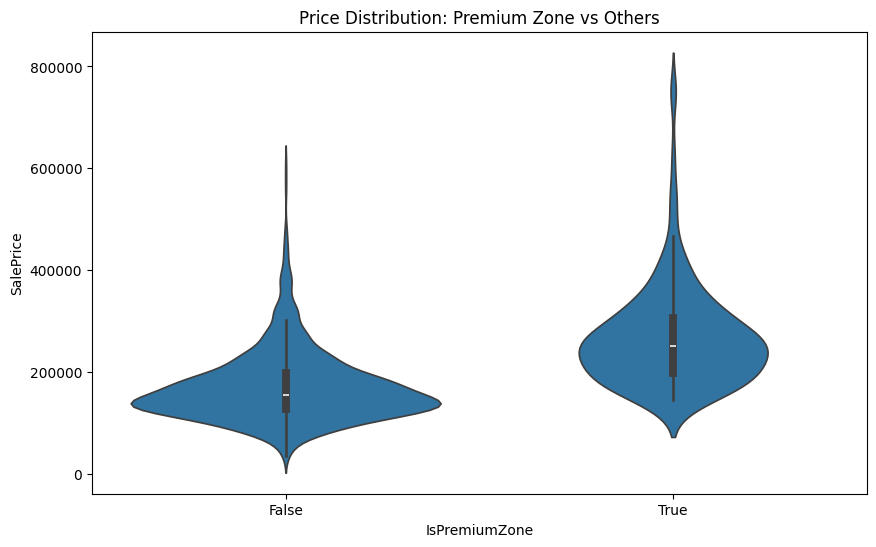

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.violinplot(x='IsPremiumZone', y='SalePrice', data=train)
plt.title('Price Distribution: Premium Zone vs Others')
plt.show()

In [15]:
comparison = train.groupby('IsPremiumZone')[['GrLivArea', 'FullBath', 'BedroomAbvGr', 'KitchenQualNum']].mean()
print(comparison)

                 GrLivArea  FullBath  BedroomAbvGr  KitchenQualNum
IsPremiumZone                                                     
False          1471.464148  1.515035      2.875096        3.438705
True           1865.570552  1.963190      2.797546        4.092025


In [16]:
premium_kitchen = train[train['IsPremiumZone'] == True]['KitchenQualNum'].value_counts()
print(premium_kitchen)

KitchenQualNum
4    128
5     25
3     10
Name: count, dtype: int64


In [17]:
kitchen_premium_price = train[train['IsPremiumZone'] == True].groupby('KitchenQualNum')['SalePrice'].mean()
print(kitchen_premium_price)

KitchenQualNum
3    197812.500
4    250038.875
5    381425.920
Name: SalePrice, dtype: float64


In [18]:
year_comparison = train.groupby('IsPremiumZone')['YearBuilt'].mean()
print(year_comparison)

IsPremiumZone
False    1967.64919
True     2000.06135
Name: YearBuilt, dtype: float64


In [20]:
vintage_luxury = train[(train['IsPremiumZone'] == True) & (train['YearBuilt'] < 1950)]
print(vintage_luxury[['YearBuilt', 'SalePrice', 'KitchenQualNum']])

Empty DataFrame
Columns: [YearBuilt, SalePrice, KitchenQualNum]
Index: []


In [21]:
modern_homes = train[train['YearBuilt'] >= 2000]
pivot_table = modern_homes.pivot_table(index='GarageCars', columns='CentralAir', values='SalePrice', aggfunc='mean')
print(pivot_table)

CentralAir              Y
GarageCars               
0           124166.666667
2           204585.956175
3           315991.194030


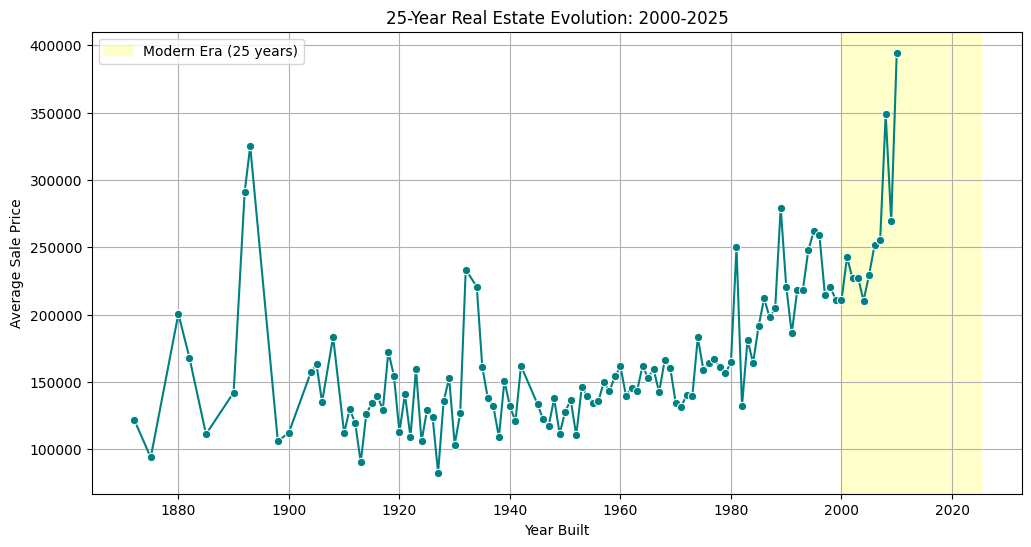

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
recent_homes = train[train['YearBuilt'] >= 2000]
yearly_trend = train.groupby('YearBuilt')['SalePrice'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_trend, x='YearBuilt', y='SalePrice', marker='o', color='teal')
plt.axvspan(2000, 2025, color='yellow', alpha=0.2, label='Modern Era (25 years)')
plt.title('25-Year Real Estate Evolution: 2000-2025')
plt.xlabel('Year Built')
plt.ylabel('Average Sale Price')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
three_car_garage = modern_homes[modern_homes['GarageCars'] == 3]
print(f"車庫3台の家の平均リビング広さ: {three_car_garage['GrLivArea'].mean():.2f} sqft")

車庫3台の家の平均リビング広さ: 1986.84 sqft
